<a href="https://colab.research.google.com/github/talhaanwarch/meat_quality_assessment/blob/main/tri_linearPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install pacakges

In [1]:
%%capture
!python3 -m pip install -U pip
!python3 -m pip install -U setuptools wheel
!python3 -m pip install -U "mxnet<2.0.0"
!python3 -m pip install autogluon

#import packages

In [2]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import KFold,LeaveOneOut,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# load data

In [3]:
import pandas as pd
files=pd.ExcelFile("https://raw.githubusercontent.com/talhaanwarch/meat_quality_assessment/main/Molen_Dataset.xlsx")
files.sheet_names  # see all sheet names



['molen_2class_testing_dwt',
 'molen_2class_testing_raw',
 'molen_2class_training_dwt',
 'molen_2class_training_raw',
 'molen_3class_testing_dwt',
 'molen_3class_testing_raw',
 'molen_3class_training_dwt',
 'molen_3class_training_raw',
 'molen_4class_testing_dwt',
 'molen_4class_testing_raw',
 'molen_4class_training_dwt',
 'molen_4class_training_raw',
 'molen_regression_testing_dwt',
 'molen_regression_testing_raw',
 'molen_regression_training_dwt',
 'molen_regression_training_raw']

In [4]:
train=files.parse("molen_3class_training_raw")
train.head()

,Label,S1,S2,S3,S4,S5,S6,S7
0,0,22.86,41.24,29.56,49.38,2.21,14.29,55.1
1,0,22.75,41.50,29.72,49.38,2.23,14.58,55.1
2,0,22.75,41.50,29.72,49.38,2.22,14.40,55.1
3,0,22.86,42.56,29.56,49.38,2.22,14.64,55.4
4,0,23.07,42.03,29.56,49.38,2.22,14.58,55.4


In [5]:
test=files.parse("molen_3class_testing_raw")
test.head()

,Label,S1,S2,S3,S4,S5,S6,S7
0,0,21.64,32.32,27.53,40.39,2.36,14.88,56.5
1,0,21.64,32.49,27.53,40.67,2.36,14.82,56.5
2,0,21.64,32.49,27.67,40.96,2.37,14.88,56.5
3,0,21.74,32.67,27.81,41.25,2.37,14.94,56.5
4,0,21.74,32.85,27.81,41.25,2.36,14.94,56.5


In [6]:
train.shape,test.shape

((700, 8), (700, 8))

In [7]:
train.Label.value_counts()

2    406
1    152
0    142
Name: Label, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


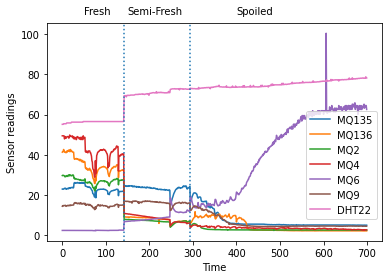

In [8]:
import matplotlib.pyplot as plt

[s1,s2,s3,s4,s5,s6,s7]=plt.plot(train.iloc[:,1::])
plt.axvline(142,ls=':')
plt.text(50,110,"Fresh")
plt.axvline(142+152,ls=':')
plt.text(150,110,"Semi-Fresh")
#plt.axvline(142+152+406)
plt.text(400,110,"Spoiled")
plt.legend([s1,s2,s3,s4,s5,s6,s7],['MQ135','MQ136','MQ2','MQ4','MQ6','MQ9','DHT22'],
           loc=('center right'),bbox_to_anchor=(1, 0.35))
plt.xlabel('Time')
plt.ylabel('Sensor readings')
plt.savefig('raw_data.eps')

In [9]:
train_feat=train.iloc[:,1::]
train_label=train.iloc[:,0]

In [10]:
test_feat=test.iloc[:,1::]
test_label=test.iloc[:,0]

# baseline models

In [11]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler=StandardScaler()
train_scaled=scaler.fit_transform(train_feat)
test_scaled=scaler.transform(test_feat)

In [12]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ]

In [13]:
f1,acc=[],[]
for clfs in classifiers:
  clfs.fit(train_scaled,train_label)
  pred=clfs.predict(test_scaled)
  f1.append(f1_score(pred,test_label,average='macro'))
  acc.append(accuracy_score(pred,test_label))

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text major ticklabel objects>)

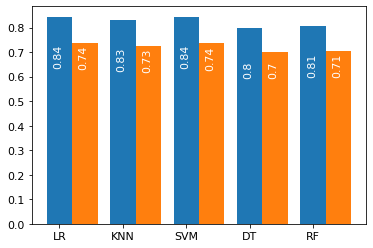

In [14]:
classifier=['LR','KNN','SVM','DT','RF']
y_pos = np.arange(len(classifier))
acc=np.array(acc)
f1=np.array(f1)
w=0.4

plt.bar(y_pos,acc,align='center',width=w,label='Accuracy')
plt.bar(y_pos+w,f1,align='center',width=w,label='F1-score')
for index, value in enumerate(acc):
    plt.text(index-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=11)

for index, value in enumerate(f1):
    plt.text(index+w-0.1,value-0.1, str(np.round(value,2)),rotation=90,color='white',fontsize=11)


plt.xticks(y_pos, classifier,fontsize=11)
plt.yticks(fontsize=11)

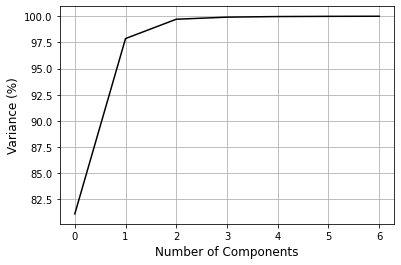

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

pca = PCA().fit(train_feat)
plt.plot(np.cumsum(pca.explained_variance_ratio_*100),color='k')
plt.xlabel('Number of Components',fontsize=12)
plt.ylabel('Variance (%)',fontsize=12) #for each component
#plt.title('Scree Plot',fontsize=12)
plt.grid()
plt.savefig('pca_scree.eps')
plt.show()

# baseline pca

In [16]:
from sklearn.decomposition import KernelPCA
#pca=KernelPCA(n_components=2, kernel='poly')
pca=PCA(2)

In [17]:
train.Label.value_counts()

2    406
1    152
0    142
Name: Label, dtype: int64

In [18]:
train_scaled_pca=pca.fit_transform(train_scaled)
test_scaled_pca=pca.transform(test_scaled)

In [19]:
f1,acc=[],[]
for clfs in classifiers:
  clfs.fit(train_scaled_pca,train_label)
  pred=clfs.predict(test_scaled_pca)
  f1.append(f1_score(pred,test_label,average='macro'))
  acc.append(accuracy_score(pred,test_label))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


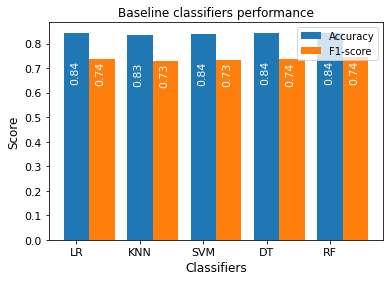

In [20]:
classifier=['LR','KNN','SVM','DT','RF']
y_pos = np.arange(len(classifier))
acc=np.array(acc)
f1=np.array(f1)
w=0.4

plt.bar(y_pos,acc,align='center',width=w,label='Accuracy')
plt.bar(y_pos+w,f1,align='center',width=w,label='F1-score')
for index, value in enumerate(acc):
    plt.text(index-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=11)

for index, value in enumerate(f1):
    plt.text(index+w-0.1,value-0.1, str(np.round(value,2)),rotation=90,color='white',fontsize=11)


plt.xticks(y_pos, classifier,fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Score',fontsize=12)
plt.xlabel('Classifiers',fontsize=12)
plt.title('Baseline classifiers performance',fontsize=12)
plt.legend()
plt.savefig('Baseline.eps',dip=300)

# auto ML

In [21]:
train_feat_pca=pca.fit_transform(train_feat)
test_feat_pca=pca.transform(test_feat)

In [22]:
train.Label.value_counts()

2    406
1    152
0    142
Name: Label, dtype: int64

In [23]:
train_pca=pd.concat([pd.DataFrame(train_feat_pca),train_label],axis=1)
train_pca.columns=['pca_{}'.format(i) for i in range(train_feat_pca.shape[1])]+['Label']
train_pca.Label=train_pca.Label.map({0:'Fresh',1:"Semi-Fresh",2:"Spoiled"})
train_pca.head()

,pca_0,pca_1,Label
0,-55.918023,22.770695,Fresh
1,-56.055396,22.904680,Fresh
2,-56.036812,22.920176,Fresh
3,-56.368246,23.145386,Fresh
4,-56.219830,22.937029,Fresh


In [24]:
train.Label.value_counts()

2    406
1    152
0    142
Name: Label, dtype: int64

In [25]:
train_pca.head()

,pca_0,pca_1,Label
0,-55.918023,22.770695,Fresh
1,-56.055396,22.904680,Fresh
2,-56.036812,22.920176,Fresh
3,-56.368246,23.145386,Fresh
4,-56.219830,22.937029,Fresh


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


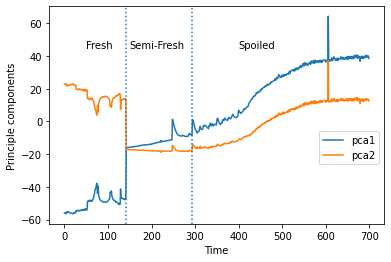

In [26]:
import matplotlib.pyplot as plt

[pca1,pca2]=plt.plot(train_pca.iloc[:,0:-1])
plt.axvline(142,ls=':')
plt.text(50,45,"Fresh")
plt.axvline(142+152,ls=':')
plt.text(150,45,"Semi-Fresh")
#plt.axvline(142+152+406)
plt.text(400,45,"Spoiled")
plt.legend([pca1,pca2],['pca1','pca2'],
           loc=('center right'),bbox_to_anchor=(1, 0.35))
plt.xlabel('Time')
plt.ylabel('Principle components')
plt.savefig('pca_data_poly.eps')

In [27]:
test_pca=pd.concat([pd.DataFrame(test_feat_pca),test_label],axis=1)
test_pca.columns=['pca_{}'.format(i) for i in range(test_feat_pca.shape[1])]+['Label']
test_pca.Label=test_pca.Label.map({0:'Fresh',1:"Semi-Fresh",2:"Spoiled"})
test_pca.head()

,pca_0,pca_1,Label
0,-47.623721,13.948260,Fresh
1,-47.798340,14.171062,Fresh
2,-47.964120,14.374942,Fresh
3,-48.225492,14.621806,Fresh
4,-48.297071,14.678736,Fresh


In [28]:
train_pca.Label.value_counts()

Spoiled       406
Semi-Fresh    152
Fresh         142
Name: Label, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


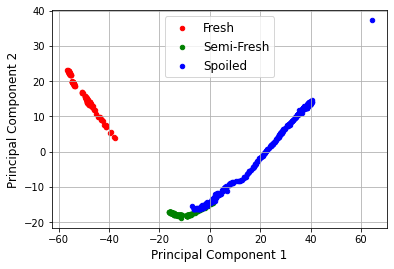

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
#ax.set_title('2 component PCA', fontsize = 20)
targets = list(train_pca.Label.unique())
colors = ['r', 'g','b']
for target, color in zip(targets,colors):
    indicesToKeep = train_pca['Label'] == target
    ax.scatter(train_pca.loc[indicesToKeep, 'pca_0']
               , train_pca.loc[indicesToKeep, 'pca_1']
               , c = color
               , s = 20)
ax.legend(targets,fontsize = 12,loc='upper center')
ax.grid()
plt.savefig('pca_plot.eps')


In [30]:
%%time
from autogluon.tabular import  TabularPredictor
clf=TabularPredictor(label='Label').fit(train_pca)

No path specified. Models will be saved in: "AutogluonModels/ag-20210531_163506/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210531_163506/"
AutoGluon Version:  0.2.0
Train Data Rows:    700
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	3 unique label values:  ['Fresh', 'Semi-Fresh', 'Spoiled']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
NumExpr defaulting to 2 threads.
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12651.13 MB
	Train Data (Original)  Memory Usage: 0.01 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manuall

CPU times: user 13 s, sys: 1.08 s, total: 14 s
Wall time: 13.9 s


In [31]:
res=clf.leaderboard(test_pca)

                  model  score_test  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              LightGBM    0.940000   0.978571        0.004632       0.002903  0.260709                 0.004632                0.002903           0.260709            1       True          5
1               XGBoost    0.828571   0.978571        0.023463       0.003512  0.131830                 0.023463                0.003512           0.131830            1       True         11
2      RandomForestGini    0.828571   0.978571        0.211882       0.103586  0.850663                 0.211882                0.103586           0.850663            1       True          6
3      RandomForestEntr    0.828571   0.978571        0.212067       0.102933  0.862490                 0.212067                0.102933           0.862490            1       True          7
4         LightGBMLarge    0.804286   0.97857

In [32]:
res['score_test']=res['score_test'].round(3)*100
res.iloc[:,0:2]

,model,score_test
0,LightGBM,94.0
1,XGBoost,82.9
2,RandomForestGini,82.9
3,RandomForestEntr,82.9
4,LightGBMLarge,80.4
5,ExtraTreesGini,80.4
6,WeightedEnsemble_L2,80.4
7,ExtraTreesEntr,80.4
8,CatBoost,79.7
9,NeuralNetFastAI,79.7


In [33]:
test_pred = clf.predict(test_pca,model=res.model[0])

In [34]:
perf = clf.evaluate_predictions(y_true=test_pca.Label, y_pred=test_pred)


Evaluation: accuracy on test data: 0.94
Evaluations on test data:
{
    "accuracy": 0.94,
    "balanced_accuracy": 0.9144945963127782,
    "mcc": 0.9064858080139754
}


In [35]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_pca.Label,test_pred))

              precision    recall  f1-score   support

       Fresh       1.00      0.80      0.89       143
  Semi-Fresh       0.89      0.95      0.92       242
     Spoiled       0.96      1.00      0.98       315

    accuracy                           0.94       700
   macro avg       0.95      0.91      0.93       700
weighted avg       0.94      0.94      0.94       700



In [36]:
 print(accuracy_score(test_pca.Label,test_pred))

0.94
